Финальный проект
Часть вторая

Курбет И.

В данной части произведем работу над задачей
Смешанная точность


Смешанная точность - это использование в модели во время обучения как 16-битных, так и 32-битных типов с плавающей запятой.  Цель - ускорение работы  и использованее меньшего кол-ва памяти. Сохраняя определенные части модели в 32-битных типах для числовой стабильности, модель будет  хорошо обучаться с точки зрения метрик оценки, таких как точность.

в большинстве моделей используется тип float32 dtype, который занимает 32 бита памяти. Однако есть тип данных с более низкой точностью, float16 . Современные ускорители могут быстрее выполнять операции в 16-битных типах данных, поскольку у них есть специализированное оборудование для выполнения 16-битных вычислений

загружаем библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import seaborn as sns
from tqdm import tqdm

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import libs
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import cv2
plt.rcParams['figure.figsize'] = [12, 10]

from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU , ReLU 
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D ,Flatten ,RepeatVector ,Reshape
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten , Dropout ,MaxPool2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential

#from tensorflow.keras.applications.imagenet_utils import preprocess_input
##imagenet_utils.preprocess_input

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import  ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import  GlobalAveragePooling2D

import random
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)
tf.compat.v1.keras.backend.set_session(SEED)


import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
print('input dir:')
os.listdir("../input/humpback-whale-identification/")


input dir:


['train.csv', 'train', 'test', 'sample_submission.csv']

In [4]:
# определим  переменные входных данных 
TRAIN_D = '../input/humpback-whale-identification/train/'
TEST_D= '../input/humpback-whale-identification/test/'
TRAIN = '../input/humpback-whale-identification/train.csv'
SAMPLE_SUB = '../input/humpback-whale-identification/sample_submission.csv'

In [5]:
train = pd.read_csv(TRAIN)
submission_df = pd.read_csv(SAMPLE_SUB)

Загрузим необходимые библиотеки, функции

In [6]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

Чтобы использовать смешанную точность в Keras,  необходимо создать tf.keras.mixed_precision.Policy .Установим 'mixed_float16' политику.  Это приведет к тому, что впоследствии созданные слои будут использовать смешанную точность со смесью float16 и float32.

In [7]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [8]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


 входные данные

In [ ]:
train.head()

In [ ]:
submission_df.head()

* Подготовим аналогично ранне проделанным действиям генераторы данных для обучения нейросетей, вспомогательные функции , определим аналогичную модель

In [9]:
# преобразование данных для целевой метки
def prepare_labels(y):  
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    N= len(label_encoder.classes_)
    return integer_encoded, N,  label_encoder

In [10]:
y,N,label_encoder = prepare_labels(train['Id'])

In [11]:
print('число классов', N)
print(y)

число классов 5005
[4786 3808  662 ... 3671 3103    0]


In [12]:
# определим метрику top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [ ]:
# модель

def model_1(input_shape_=(112,112,3) , N=5005):
    model = Sequential()
  
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', 
                     activation = 'relu', input_shape = input_shape_))
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))


    
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu", name='rl'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(N,  name='sm'))
    model.add(Activation('softmax', dtype='float32', name='predictions'))
    
    optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])
    return model

In [ ]:
# Списки генераторов 
train_data_gen_list = []
train_generator_list = []
valid_generator_list = []



In [ ]:
# 0 base data Generator
train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    validation_split=0.12)
test_data_gen = ImageDataGenerator(rescale=1/255.,preprocessing_function=imagenet_utils.preprocess_input)


train_data_gen_list.append(train_data_gen)


# 1 flip

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    horizontal_flip=True,
                                    validation_split=0.12)

train_data_gen_list.append(train_data_gen)


# 2 rotation

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    rotation_range=20,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 3 wshift

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    width_shift_range=.1,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)


# 4 hshift

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    height_shift_range=.1,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 5 brightness

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    brightness_range=(0.8,1.2),
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)


# 6 shear

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    shear_range=10,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 7 zoom

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    zoom_range=0.2,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 8 all

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    zoom_range=0.2,
                                    shear_range=10,
                                    brightness_range=(0.8,1.2),
                                    height_shift_range=.1,
                                    width_shift_range=.1,
                                    rotation_range=20,
                                    horizontal_flip=True,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

In [ ]:
train_data_gen_list

In [ ]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=submission_df,
    directory=TEST_D,
    x_col='Image',
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(112, 112)
)



for g in train_data_gen_list:
    train_generator = g.flow_from_dataframe(
        dataframe=train,
        directory=TRAIN_D,
        x_col='Image',
        y_col='Id',
        shuffle=True,
        subset="training",
        batch_size=32,
        seed=42,
        class_mode="categorical",
        target_size=(112, 112)
    )

    valid_generator = g.flow_from_dataframe(
        dataframe=train,
        directory=TRAIN_D,
        x_col='Image',
        y_col='Id',
        shuffle=False,
        subset="validation",
        batch_size=32,
        seed=42,
        class_mode="categorical",
        target_size=(112, 112)
    )

    train_generator_list.append(train_generator)
    valid_generator_list.append(valid_generator)









In [ ]:
def _get_lmap(gen):
    return dict((v,k) for k,v in gen.class_indices.items())

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

In [ ]:
for j in [8]:
    print(j)
    simp_mod= model_1()
    trg = train_generator_list[j]
    vg  = valid_generator_list[j]

    trg.reset()
    vg.reset()
    
    STEP_SIZE_TRAIN=trg.n//trg.batch_size
    STEP_SIZE_VALID=vg.n//vg.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
    print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
    print('STEP_SIZE_TEST:',STEP_SIZE_TEST)
    
    

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_5_accuracy',
    mode='max',
    save_best_only=True)


    print('train')
    history= simp_mod.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 ,callbacks=[model_checkpoint_callback])

    simp_mod.load_weights(checkpoint_filepath)
    
       
    label_map = _get_lmap(trg)
    
    col = ['Image']
    test_data = pd.DataFrame(submission_df['Image'], columns=col)
    test_data['Id'] = ''
    test_generator.reset()
    print('predict')
    predictions=simp_mod.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
    for i, pred in enumerate(predictions):
        lst =[label_map[ind] for ind in pred.argsort()[-5:][::-1]]
        test_data.loc[i, 'Id'] = ' '.join(lst)
        
    test_data.to_csv('submission_float16_ex_'+str(j)+'_.csv', index=False)

In [13]:
Results = pd.DataFrame()
Results

""


In [14]:
Results['Public'] = [0.29988 ,0.28798 , 0.31235 , 0.28784]
Results['Private'] = [0.31408  ,0.30465 , 0.32577 , 0.30436]
Results['Comment'] =['Base Gen' ,  'All Gen' , 'Base  float16' ,  'All Gen  float16']

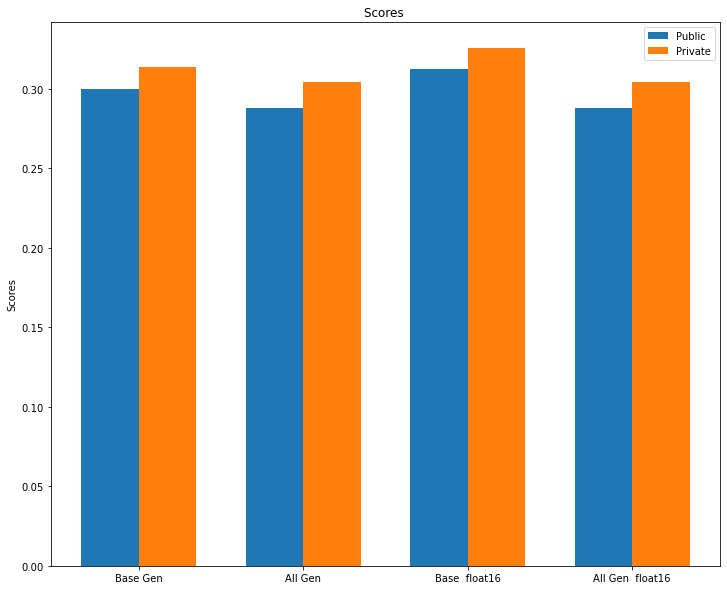

In [15]:
ind = np.arange(len(Results['Public']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, Results['Public'], width, 
                label='Public')
rects2 = ax.bar(ind + width/2, Results['Private'], width, 
                label='Private')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores ')
ax.set_xticks(ind)
ax.set_xticklabels(Results['Comment'])
ax.legend()